<header>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/47/Logo_UTFSM.png" width=150 alt="UTFSM" align="left"/>
<img src="./images/dmat.png" width = 180 alt="DMAT" align="right" style="margin:20px 0px"/>
</header>

<p style="font-size:50px;text-align:center;margin:25px 0px">Protein Data Bank</p>

---

## Cristóbal Cancino, Tomás Cortés, Bruno Martinez
Aplicaciones de la Matemática en la Ingeniería - MAT281 </br>
**Profesor**: Alonso Ogueda </br>
Universidad Técnica Federico Santa María

---

# Definición del problema

> Se utilizará una base de datos sobre proteinas entregada por _Research Collaboratory for Structural Bioinformatics (RCSB)_ de _Protein Data Bank (PDB)_, la cual es un depósito de coordenadas atómicas y otra información que describe proteínas y otras macromoléculas biológicas importantes. Los biólogos estructurales utilizan métodos como la cristalografía de rayos X, la espectroscopia de RMN y la microscopía crioelectrónica para determinar la ubicación de cada átomo en relación con los demás en la molécula. Luego depositan esta información, que luego es anotada y publicada públicamente en el archivo por wwPDB.
>
>> ### Motivación 
El PDB en constante crecimiento es un reflejo de la investigación que se lleva a cabo en los laboratorios de todo el mundo. Esto puede hacer que el uso de la base de datos en la investigación y la educación sea emocionante y desafiante. Las estructuras están disponibles para muchas de las proteínas y ácidos nucleicos involucrados en los procesos centrales de la vida, por lo que puede ir al archivo de PDB para encontrar estructuras para ribosomas, oncogenes, dianas de fármacos e incluso virus completos. Sin embargo, puede ser un desafío encontrar la información que necesita, ya que la PDB archiva tantas estructuras diferentes. A menudo encontrará múltiples estructuras para una molécula determinada, o estructuras parciales, o estructuras que han sido modificadas o inactivadas de su forma nativa.
>
> Recuperado de [Structural Protein Sequence](https://www.kaggle.com/shahir/protein-data-set?select=pdb_data_no_dups.csv)

In [2]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
from scipy import stats
from scipy.stats import norm, skew, kurtosis
import seaborn as sns
from sklearn.model_selection import train_test_split

## Estudio de la base de datos: pdb_data_no_dups.csv

In [8]:
data_no_dups_path = os.path.join("data", "pdb_data_no_dups.csv")
pdb_no_dups = pd.read_csv(data_no_dups_path)
#sum(pdb_no_dups['classification'].value_counts()[:10]) / pdb_no_dups['classification'].count()
pdb_no_dups.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


> Esta base de datos contiene las siguientes columnas
>
> 1. **structureid**: Indexación para identificar la estructura en particular.
> 2. **clasification**: Estructura en estudio.
> 3. **experimentalTechnique**: Técnica usada para determinar la ubicación relativa entre cada átomo de la molecula.
> 4. **macromoleculeType**: Tipo de macromolecula correspondiente a la estructura.
> 5. **residueCount**: Número de residuos, es decir, el número de monómeros que componen la macromolécula.
> 6. **resolution**: Resolución del microscopío. Para cada resolución, se tiene la siguiente interpretación:
> 
>| Resolución | Interpretación                                                                                                                                                                                                              |
|------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| >4.0       | Coordenadas individuales sin significado                                                                                                                                                                                    |
| 3.0 - 4.0  | Plegamiento posiblemente correcto, pero comúnmente con errores. Algunas cadenas laterales poseen mal los rotámeros.                                                                                                         |
| 2.5 - 3.0  | Plegamiento bien dilucidado salvo en algunos pliegues superficiales, mal modelados. Algunas cadenas laterales largas (Lys, Glu, Gln) y otras cortas (Ser, Val, Thr) mal orientadas.                                        |
| 2.0 - 2.5  | El número de cadenas laterales con un rotámero incorrecto es mucho menor. Los errores, pequeños, son detectados normalmente. Los pliegues superficiales están bastante bien definidos. Los ligandos y el agua son visibles. |
| 1.5 - 2.0  | Pocos residuos poseen mal rotámero. Los errores pequeños son detectados. Los pliegues incorrectos son muy raros, incluso en superficie.                                                                                     |
| 0.5 - 1.5  | En general, todo está corrctamente resuelto. Las librerías de rotámeros y los estudios geométricos se hacen a este nivel de precisión.                                                                                      |
>
>7. **structureMoleculeWeight**: Masa molar de la estructura
>8. **cristalizationMethod**: Método de critalización. Aquellos experimentos que no consideran cristalización les corresponde NaN.
>9. **crystalizationTemperature**: Temperatura de cristalización. Idem.
>10. **densityMatthews**: Densidad de Matthews, dada por $$\frac{\text{volumen}}{\text{peso molecular} * Z * X},$$ donde $Z$ es el número de unidades asimétricas en la unidad celular y $X$ es el número de moleculas en la unidad asimétrica.
>11. **densitityPercentSol**: Porcentaje de densidad de la solución.
>12. **pdbxDetails**: Detalles extra del experimento.
>13. **phValue**: Valor del pH.
>14. **publicationYear**: Año de publicación.

## Estudio de la base de datos pdb_data_seq.csv

In [6]:
data_seq_path = os.path.join("data", "pdb_data_seq.csv")
pdb_seq = pd.read_csv(data_seq_path)
pdb_seq.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


>Esta base de datos contiene las siguientes columnas
>
>1. **structureid**: Indexación para identificar la estructura en particular.
>2. **chainId**: Cadena de la estructura.
>3. **sequence**: Secuencia molecular de la macromolécula.
>4. **macromoleculeType**: Tipo de macromolecula correspondiente a la estructura
>5. **residueCount**: Número de residuos, es decir, el número de monómeros que componen la macromolécula.

---

# ¿Cuál es la pregunta que deseamos resolver?

> ¿Podemos predecir la columna ``sequence`` o la columna ``clasification`` utilizando el resto de features mediante modelos?

---

# Análisis estadístico de los datos.

### pdb_data_no_dups.csv

In [9]:
pdb_no_dups.describe(include="all").T.fillna("")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
structureId,141401.0,140911,1UJQ,4,,,,,,,
classification,141399.0,5050,HYDROLASE,20915,,,,,,,
experimentalTechnique,141401.0,33,X-RAY DIFFRACTION,126432,,,,,,,
macromoleculeType,137636.0,13,Protein,127798,,,,,,,
residueCount,141401.0,,,,825.375,2136.46,0,226,414,820,313236
resolution,128589.0,,,,2.26381,1.41088,0.48,1.8,2.1,2.5,70
structureMolecularWeight,141401.0,,,,112079,569015,314.38,26128.6,47477.8,94084.8,9.77305e+07
crystallizationMethod,96242.0,549,"VAPOR DIFFUSION, HANGING DROP",53870,,,,,,,
crystallizationTempK,97039.0,,,,290.968,9.54108,4,290,293,295,398
densityMatthews,124724.0,,,,2.67027,0.78374,0,2.21,2.49,2.91,99


In [10]:
pdb_no_dups.dtypes

structureId                  object
classification               object
experimentalTechnique        object
macromoleculeType            object
residueCount                  int64
resolution                  float64
structureMolecularWeight    float64
crystallizationMethod        object
crystallizationTempK        float64
densityMatthews             float64
densityPercentSol           float64
pdbxDetails                  object
phValue                     float64
publicationYear             float64
dtype: object

### pdb_data_no_dups.csv

In [11]:
pdb_seq.describe(include="all").T.fillna("")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
structureId,467304.0,140250,3J3Q,1356,,,,,,,
chainId,467294.0,2836,A,135187,,,,,,,
sequence,467276.0,104812,PIVQNLQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEG...,5112,,,,,,,
residueCount,467304.0,,,,6173.43,23645.6,0,456,1131,4342,313236
macromoleculeType,432487.0,13,Protein,345180,,,,,,,


In [12]:
pdb_seq.dtypes

structureId          object
chainId              object
sequence             object
residueCount          int64
macromoleculeType    object
dtype: object

> Se construirá la función ```triple_distribution_plot```, a partir del paquete ```seaborn```. Esta función nos permitirá la distribución de tres categorías disponibles en las bases de datos. </br>
> De esta forma, se procederá a estudiar las distribuciones de los valores según nuestro interés.

In [16]:
def triple_distribution_plot(df, input1, input2, input3):
    f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
    
    sns.kdeplot(df[input1],ax = ax1,color ='blue',shade=True,
                label=("Asimetría : %.2f"%(df[input1].skew()),
                       "Curtosis: %.2f"%(df[input1].kurtosis())))
    sns.kdeplot(df[input2], ax = ax2,color='r',shade=True,
                label=("Asimetría : %.2f"%(df[input2].skew()),
                       "Curtosis: %.2f"%(df[input2].kurtosis())))
    sns.kdeplot(df[input3], ax = ax3,color='gray',shade=True,
                label=("Asimetría : %.2f"%(df[input3].skew()),
                       "Curtosis: %.2f"%(df[input3].kurtosis())))
    
    axes = [ax1,ax2,ax3]
    input = [input1,input2,input3]
    
    for j in range(len(axes)):
        axes[j].set_xlabel(input[j],color='black',fontsize=12)
        axes[j].set_title(input[j], fontsize=14)
        axes[j].axvline(df[input[j]].mean() , color ='g',linestyle = '--')
        axes[j].legend(loc ='upper right',fontsize=12,ncol=2)
    sns.despine()
    
    return plt.show()

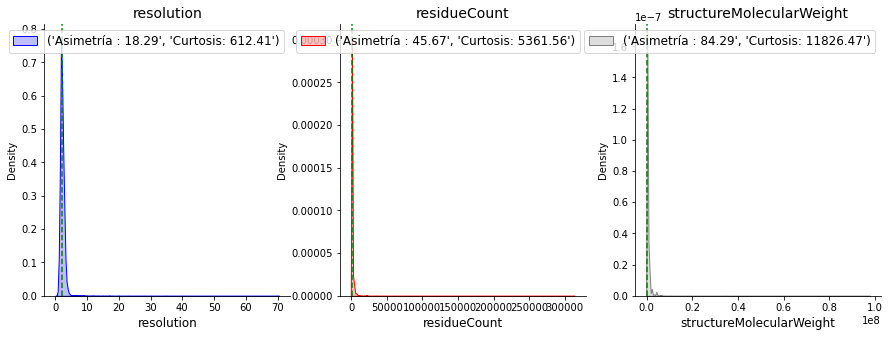

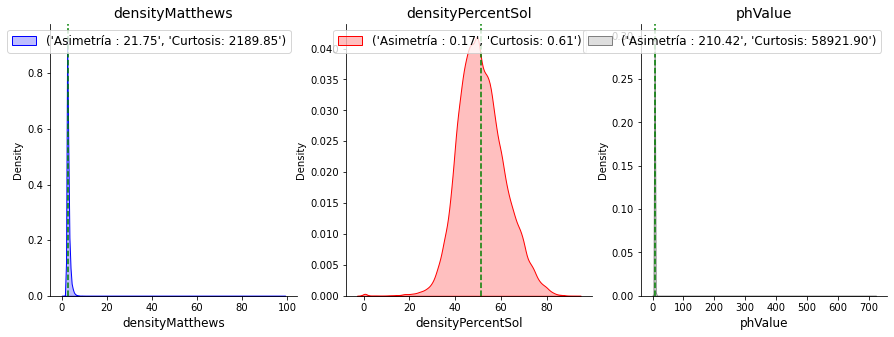

In [17]:
triple_distribution_plot(pdb_no_dups, 'resolution','residueCount','structureMolecularWeight')
triple_distribution_plot(pdb_no_dups, 'densityMatthews','densityPercentSol','phValue')

In [ ]:
sns.pairplot(pdb_no_dups)
sns.set(style="ticks", color_codes=True)

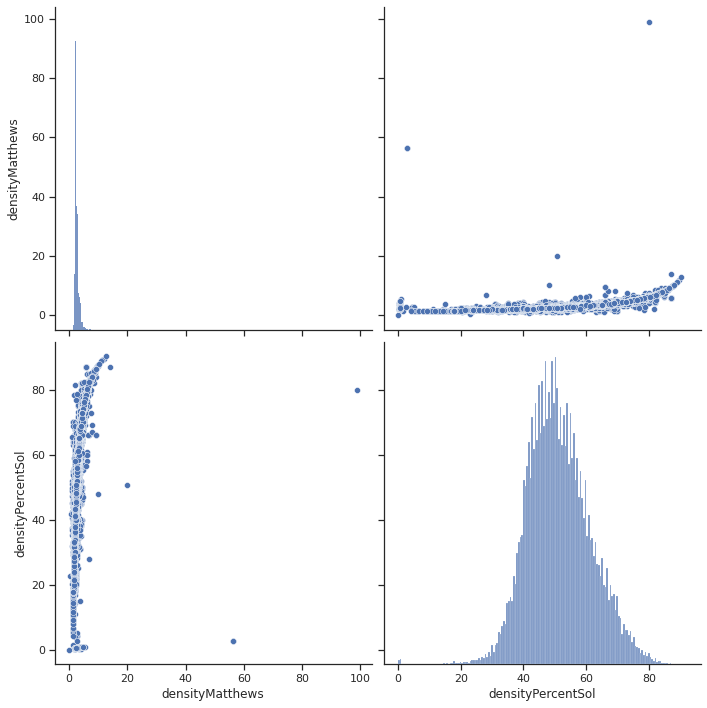

In [21]:
sns.pairplot(pdb_no_dups[['densityMatthews','densityPercentSol']], height = 5)
sns.set(style="ticks", color_codes=True)

## Estadística descriptiva

a

## Visualización descriptiva

a

## Preprocesamiento

a

## Selección de modelo

a

## Métricas y análisis de resultados

a

## Visualizaciones del modelo

a

## Conclusiones

a